In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
syn_T = 351
C_den = torch.tensor([0,1,1,1,1])
sub_no = C_den.shape[0]

batch_size = 1250

syn_basis_no = 3
hist_basis_no = 3
spike_status = True
hist_T = 251


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
N = torch.sum(Ensyn) + torch.sum(Insyn)
print(N)

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

tensor(749)


# Train ALL Params

In [4]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
fit_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_s3_h3_shglm_i13500.pt"))


V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
#adjust_K_hist = torch.ones(sub_no, hist_basis_tau.shape[0])*(-0.05)
#adjust_thresh = torch.ones(sub_no)*13
#adjust_spike_size = torch.ones(sub_no)*20
#adjust_thresh_scale = torch.ones(sub_no)*10
adjust_K_hist = torch.ones(sub_no, hist_basis_no)*(0.05)
adjust_thresh = torch.ones(sub_no)*7
adjust_spike_size = torch.ones(sub_no)*5
adjust_thresh_scale = torch.ones(sub_no)*5

with torch.no_grad():
    fit_shGLM.K_hist = nn.Parameter(adjust_K_hist.float(), requires_grad=True)
    fit_shGLM.thresh = nn.Parameter(adjust_thresh.float(), requires_grad=True)
    fit_shGLM.spike_size = nn.Parameter(adjust_spike_size, requires_grad=True)
    fit_shGLM.thresh_scale = nn.Parameter(adjust_thresh_scale, requires_grad=True)
    
fit_shGLM.cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37500
37500


In [8]:
no_spike_bool = True
spike_bool = True

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = no_spike_bool
fit_shGLM.Delta.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = no_spike_bool

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool
fit_shGLM.thresh_scale.requires_grad = spike_bool


In [9]:
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.01)
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.005)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0005)

In [ ]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    fit_shGLM.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        fit_shGLM.eval()
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%100 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s3_h3_shglm_i"+str(i)+".pt")
    


<ipython-input-10-10ac37ba0e17>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 7.892198507274732 0.4285699094385562 0.39613631508465386
TEST 100 13.780652607337812 0.0022197794585333552 0.02906819129946736


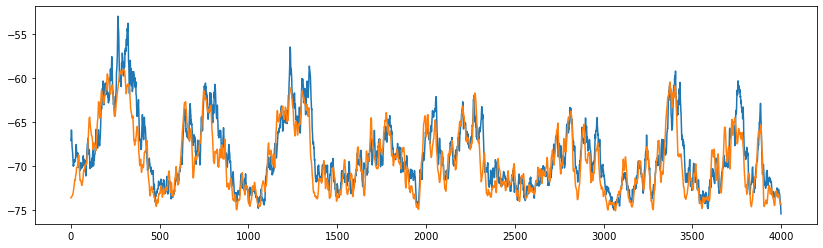

In [13]:
plt.figure(figsize=(14,4))
plt.plot(test_V_ref.cpu().detach().numpy()[:4000])
plt.plot(test_pred.cpu().detach().numpy()[:4000]-1)

In [1]:
for name, param in fit_shGLM.named_parameters():
    print(name, param.data)

NameError: name 'fit_shGLM' is not defined

# Test Params

In [5]:
final_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s3_h3_shglm_i1500.pt"))

final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

test_V_final = test_V_final
test_V_ref = test_V_ref

0.03138842421798007


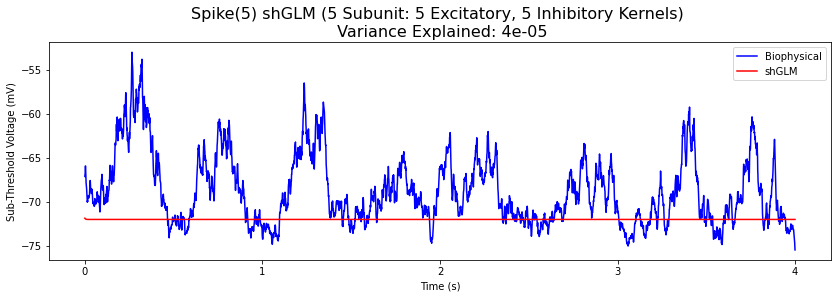

In [7]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]-0.4, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Spike(5) shGLM (5 Subunit: 5 Excitatory, 5 Inhibitory Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
plt.show()


#plt.savefig("/media/hdd01/sklee/shglm/biophysical/final5_spike10.png", dpi=150, bbox_inches='tight')

In [8]:
for name, param in final_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-71.7179], device='cuda:0')
K_syn tensor([[[ 0.0039, -0.0673],
         [-0.0081,  0.0270],
         [ 0.0074, -0.1066]],

        [[ 0.1065, -0.0926],
         [-0.2315,  0.1013],
         [ 0.1274, -0.1342]],

        [[ 0.0610, -0.1321],
         [-0.2430,  0.1010],
         [ 0.1080, -0.1596]],

        [[ 0.0554, -0.1222],
         [-0.1930,  0.1148],
         [ 0.1102, -0.1684]],

        [[ 0.1094, -0.1376],
         [-0.2005,  0.1457],
         [ 0.1613, -0.1941]]], device='cuda:0')
syn_basis_tau tensor([1.5587, 2.0728, 2.6208], device='cuda:0')
Delta tensor([4.9588], device='cuda:0')
C tensor([3.5030, 0.6319, 0.8466, 0.7831, 0.5112], device='cuda:0')
Theta tensor([3.2892, 0.9269, 1.7992, 1.1919, 1.1982], device='cuda:0')
thresh tensor([7.1079, 7.0910, 7.0916, 7.0904, 7.0911], device='cuda:0')
thresh_scale tensor([4.8987, 4.9248, 4.9164, 4.9144, 4.9350], device='cuda:0')
spike_size tensor([4.8909, 4.9043, 4.9074, 4.9079, 4.9039], device='cuda:0')
hist_basis_tau tens